## Zadanie 1 - Analiza obrazów

In [1]:
# przydatne funkcje numpy.fft.fft2, numpy.rot90, numpy.multiply, numpy.amax, numpy.fft.fft2

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as img
import numpy.fft as fft

from PIL import Image, ImageFilter, ImageOps

### Wspólne funkcje

In [2]:
def show_image(image, scale=10):
    plt.figure(figsize=(image.width//scale, image.height//scale))
    plt.imshow(image)
    plt.show()


def find_pattern_in(image, pattern, sensitivity=0.95):
    inv_img = ImageOps.invert(image)
    inv_pattern = ImageOps.invert(pattern)

    corr = correlation_between(np.array(inv_img.convert('L')), np.array(inv_pattern.convert('L')))

    image_maximas = find_maxima(corr, sensitivity)
    corr[~image_maximas] = 0

    img_with_marks = mark_pattern(np.array(image), np.array(inv_pattern).shape, image_maximas)

    Image.fromarray(img_with_marks).show()
    return (len(corr[image_maximas]), image_maximas)

    
def correlation_between(image, pattern):
    fft1 = np.fft.fft2(image, axes=(0,1))
    fft2 = np.fft.fft2(np.rot90(pattern, k=2), axes=(0,1), s=(len(image),len(image[0])))
    C = np.fft.ifft2(np.multiply(fft1, fft2), axes=(0,1))
    
    return np.real(C)


def find_maxima(image, scale):
    return image > (scale*np.amax(image))


# image in RGB coding
def mark_pattern(image, pattern_shape, correlation):
    
    for i in range(1, image.shape[0]-pattern_shape[0]):
        for j in range(1, image.shape[1]-pattern_shape[1]):
            if correlation[i][j]:
                draw_square_around(image, (i, j), pattern_shape[0], pattern_shape[1]) 
                
    return image


def mark_pattern_with_checking(image, pattern_shape, correlation):
    
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
            if correlation[i][j]:
                if correlation[i-1][j] and correlation[i+1][j] and correlation[i][j-1] and correlation[i][j+1]:
                    draw_square_around(image, (i, j), pattern_shape[0], pattern_shape[1]) 
                
    return image


def draw_square_around(image, point, height, width):
    bottom = point[0] - height
    top = point[0]
    left = point[1] - width
    right = point[1]
    
    if bottom>=0 and top<image.shape[0] and left>=0 and right<image.shape[1]:
        for i in range(left, right+1):
            image[top][i] = [255, 0, 0]
            image[bottom][i] = [255, 0, 0]

        for i in range(bottom, top+1):
            image[i][left] = [255, 0, 0]
            image[i][right] = [255, 0, 0]



### Wyszukiwanie wzorca w obrazie tekstu (Galia.png)

In [4]:
galia = Image.open('galia.png').convert('RGB')
galia_e = Image.open('galia_e.png').convert('RGB')

counter = find_pattern_in(galia, galia_e, 0.95)[0]

print(np.array(galia_e).shape)
print('Liczba dopasowań wzorca: ', counter)

(13, 13, 3)
Liczba dopasowań wzorca:  43


### Wyszukiwanie wzorca w obrazie (School.jpg)

In [247]:
school = Image.open('school.jpg').convert('RGB')
fish = Image.open('fish1.png').convert('RGB')

inv_school = ImageOps.invert(school)
inv_fish = ImageOps.invert(fish)

corr = correlation_between(np.array(inv_school.convert('L')), np.array(inv_fish.convert('L')))

# plt.imshow(correlation.filter(ImageFilter.SMOOTH))

image_maximas = find_maxima(corr, 0.95)
corr[~image_maximas] = 0

school_with_marks = mark_pattern_with_checking(np.array(school), np.array(inv_fish).shape, image_maximas)

Image.fromarray(school_with_marks).show()

print(np.array(inv_fish).shape)
print('Liczba dopasowań wzorca: ', len(corr[image_maximas]))


(15, 38, 3)
Liczba dopasowań wzorca:  101631


## Zadanie 2 - OCR

### Stałe

In [104]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as img
import numpy.fft as fft

from PIL import Image, ImageFilter, ImageOps

# Merriweather:
# more sensitivity: h(98%), q(98%?), u(98%), m(97%)
# normal sensitivity : 95% (r - 96%)
# less sensitivity: b (95% max), i (90%), t(90%), c(80%),  n(93%)

known_characters = ['a', 'e', 'k', 'p', 'd', 'g', 'f', 's', 'y', 'w', 'h', 
                    'r', 'v', 'l', 'b', 'z', 'i', 't', 'q', 'j', 'u', 
                    'W', 'K', 'Y', 'O', 
                    'V', 'X', 'T', 'S', 'M', 'N', 'Q', 'Z', 'U', 'R', 'P', 'H', 'E', 'L', 'F', 
                    'A', 'G', 'J', 'D', 'C', 'I', 'B', 
                    'm', 'n', 'o', 'x', 'c', 
                    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', #] 
                    ',', '.', ' ' ] #, '?', '!', ';', ':']

capital_letters = { 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 
                    'T', 'V', 'U', 'W', 'X', 'Y', 'Z'}

characters_files = {'0': 'zero.png', '1': 'one.png', '2': 'two.png', '3': 'three.png', '4': 'four.png', '5': 'five.png', 
                   '6': 'six.png', '7': 'seven.png', '8': 'eight.png', '9': 'nine.png', 
                   ',': 'comma.png', '.': 'period.png', '?': 'question.png', '!': 'exclam.png', ';': 'semicolon.png', 
                   ':': 'colon.png', ' ': 'space.png'}

big_sensitivity = {'h': 0.98, 'q': 0.98, 'u': 0.98, 'm': 0.97}
small_sensitivity = {'b': 0.95, 'n': 0.93, 'i': 0.9, 't': 0.85, 'c': 0.8}

characters_shapes = {}

merriweather_path = ".\\fonts\\Serif\\Merriweather\\"
lora_path = ".\\fonts\\Serif\\Lora\\"
open_sans_path = ".\\fonts\\Sans-serif\\OpenSans\\"
oswald_path = ".\\fonts\\Sans-serif\\Oswald\\"

### Funkcje

In [105]:
sample = ImageOps.invert(Image.open(merriweather_path + 'sample.png'))
sample_rgb = np.array(sample)

def ocr(image, font_name, is_serif, is_rotated):
    img = np.array(image)
    found_letters = {}
    content = ''
    
    for character in known_characters:
        print(character)
        pattern = get_letter_pattern(character, font_name)
        
        if character in big_sensitivity.keys():
            placements = find_char_placements_in(img, pattern, character, big_sensitivity[character])
        elif character in small_sensitivity.keys():
            placements = find_char_placements_in(img, pattern, character, small_sensitivity[character])
        else:
            placements = find_char_placements_in(img, pattern, character, 0.95)
        
        print("Before taken: ", placements)
        remove_colliding(found_letters, placements, pattern.shape)
        print("Before duplicats: ", placements)
        remove_duplicats(placements, pattern.shape)
        print("Before add: ", placements)
        found_letters.update(placements)
    
    
    get_letter_pattern(' ', font_name)
    
    text = get_text_from_positions(found_letters, img.shape)
    #for key in sorted(sorted(found_letters.keys(), key=lambda pos: pos[1]), key=lambda pos: pos[0]):
    #    print(key, found_letters[key])
    #    content = content + found_letters[key]
    
    #plt.imshow(sample_rgb)
    
    print("Max height: ", max(characters_shapes.values(), key=lambda elem: elem[0]))
    print("Found letters: ", found_letters)
    print("Len: ", len(text))
    print(characters_shapes['e'])
    return text
    

def find_char_placements_in(image, pattern, character, sensitivity):
    placements = {}
    
    corr = correlation(image, pattern)
    maximas = corr > sensitivity*np.amax(corr)
    corr[~maximas] = 0
    
    for i in range(maximas.shape[0]):
        for j in range(pattern.shape[1], maximas.shape[1]):
            if maximas[i][j]:
                placements[(i,j-pattern.shape[1])] = character
    
    #remove_duplicats(placements, pattern.shape)
    #mark_pattern(sample_rgb, pattern.shape, corr)
    
    return placements

    
def correlation(image, pattern):
    fft1 = np.fft.fft2(image, axes=(0,1))
    fft2 = np.fft.fft2(np.rot90(pattern, k=2), axes=(0,1), s=(len(image),len(image[0])))
    C = np.fft.ifft2(np.multiply(fft1, fft2), axes=(0,1))
    
    return np.real(C)


def remove_duplicats(placements, pattern_shape):
    to_remove = []
    
    for key1 in placements.keys():
        for key2 in placements.keys():
            if (key1 != key2 and key1 not in to_remove and key2 not in to_remove):
                if (abs(key1[0]-key2[0]) < pattern_shape[0] and abs(key1[1]-key2[1]) < pattern_shape[1]*0.9):
                    to_remove.append(key2)
                    #print("Removing: ", key1, key2)
                    
    for key in to_remove:
        placements.pop(key)


def remove_colliding(placements, patt_placements, patt_shape, sensitivity = 0.9):
    to_remove = []
    
    for key1 in placements.keys():
        for key2 in patt_placements.keys():
            if (key2 not in to_remove and abs(key1[0]-key2[0]) < patt_shape[0]):
                key1_height, key1_width = characters_shapes[placements[key1]]
                #if (abs(key1[0]-key2[0]) < patt_shape[0] and abs(key1[1]-key2[1]) < patt_shape[1]*0.75):
                if (key2[1]<key1[1] and key1[1]-key2[1]<sensitivity*patt_shape[1]) or (key2[1]>key1[1] and key2[1]-key1[1]<sensitivity*key1_width) or key2[1]==key1[1]:
                    to_remove.append(key2)
                    
    for key in to_remove:
        patt_placements.pop(key)

        
def get_text_from_positions(placements, image_shape):
    lines = []
    line = []
    text = ''
    first = sorted(placements.keys(), key=lambda elem: elem[0])[0]
    
    for key in sorted(placements.keys(), key=lambda elem: elem[0]):
        if abs(key[0]-first[0]) >= max(characters_shapes.values(), key=lambda elem: elem[0])[0]:
            lines.append(line)
            line = []
            first = key
        line.append(key)
        if key == sorted(placements.keys(), key=lambda elem: elem[0])[-1]:
            lines.append(line)
        
    space_width = characters_shapes[' '][1]
    # max_width = max(characters_shapes.values(), key=lambda elem: elem[1])[1]
    prev_key = sorted(lines[0], key=lambda elem: elem[1])[0]
    # characters_shapes[placements[key]][1]
    for line in lines:
        for key in sorted(line, key=lambda elem: elem[1]):
            if key!=prev_key and abs(key[1]-prev_key[1]-characters_shapes[placements[key]][1]) >= space_width*0.9 and abs(key[1]-prev_key[1]-characters_shapes[placements[key]][1]) < space_width*1.4:
                #print("Space: ", space_width, abs(key[1]-prev_key[1]-characters_shapes[placements[key]][1]), placements[key], key, placements[prev_key], prev_key)
                text = text + ' '
            text = text + placements[key]
            prev_key = key
        text = text + '\n'
                
    return text


def get_letter_pattern(char, font_name):
    #size = (int(patt.width/2.1), int(patt.height/3.1))
    path = ''
    
    if font_name == 'merriweather':
        path = merriweather_path
    elif font_name == 'lora':
        path = lora_path
    elif font_name == 'open-sans':
        path = open_sans_path
    else:
        path = oswald_path
    
    if char in characters_files.keys():
        path = path + characters_files[char]
    elif char in capital_letters:
        path = path + char + '_capital.png'
    else:
        path = path + char + '.png'
        
    img = ImageOps.invert(Image.open(path).convert('RGB')).convert('L')
    img = np.array(img.resize((int(img.width/2.1), int(img.height/3.1)), resample=Image.LANCZOS))
    
    characters_shapes[char] = img.shape
    
    return img


### Przykłady użycia

Shape or:  (288, 883, 3)
a
Before taken:  {(130, 105): 'a', (130, 631): 'a', (131, 105): 'a', (131, 631): 'a', (190, 494): 'a', (190, 542): 'a', (190, 790): 'a', (191, 493): 'a', (191, 494): 'a', (191, 542): 'a', (191, 789): 'a', (191, 790): 'a', (250, 173): 'a', (251, 173): 'a'}
Before duplicats:  {(130, 105): 'a', (130, 631): 'a', (131, 105): 'a', (131, 631): 'a', (190, 494): 'a', (190, 542): 'a', (190, 790): 'a', (191, 493): 'a', (191, 494): 'a', (191, 542): 'a', (191, 789): 'a', (191, 790): 'a', (250, 173): 'a', (251, 173): 'a'}
Before add:  {(130, 105): 'a', (130, 631): 'a', (190, 494): 'a', (190, 542): 'a', (190, 790): 'a', (250, 173): 'a'}
e
Before taken:  {(71, 93): 'e', (71, 188): 'e', (71, 263): 'e', (71, 264): 'e', (71, 306): 'e', (71, 439): 'e', (71, 500): 'e', (71, 570): 'e', (71, 607): 'e', (71, 644): 'e', (71, 712): 'e', (71, 713): 'e', (71, 758): 'e', (71, 759): 'e', (131, 165): 'e', (131, 166): 'e', (131, 331): 'e', (131, 332): 'e', (131, 497): 'e', (131, 530): 'e', (1

Before taken:  {(70, 745): 't', (71, 205): 't', (71, 206): 't', (71, 424): 't', (71, 425): 't', (71, 559): 't', (71, 745): 't', (71, 746): 't', (71, 793): 't', (72, 745): 't', (130, 672): 't', (131, 76): 't', (131, 261): 't', (131, 310): 't', (131, 409): 't', (131, 410): 't', (131, 483): 't', (131, 564): 't', (131, 649): 't', (131, 650): 't', (131, 671): 't', (131, 672): 't', (131, 726): 't', (131, 727): 't', (132, 672): 't', (190, 374): 't', (190, 716): 't', (191, 128): 't', (191, 129): 't', (191, 248): 't', (191, 374): 't', (191, 395): 't', (191, 560): 't', (191, 561): 't', (191, 676): 't', (191, 677): 't', (191, 716): 't', (192, 716): 't', (250, 133): 't', (251, 133): 't', (251, 215): 't', (251, 358): 't'}
Before duplicats:  {(71, 206): 't', (71, 424): 't', (71, 425): 't', (71, 793): 't', (131, 76): 't', (131, 409): 't', (131, 410): 't', (131, 483): 't', (131, 564): 't', (131, 649): 't', (131, 650): 't', (131, 726): 't', (131, 727): 't', (191, 128): 't', (191, 129): 't', (191, 560):

Before taken:  {(70, 491): 'x', (71, 491): 'x', (191, 170): 'x', (191, 689): 'x', (249, 360): 'x', (250, 330): 'x', (250, 360): 'x', (251, 227): 'x', (251, 330): 'x', (251, 331): 'x', (251, 360): 'x'}
Before duplicats:  {}
Before add:  {}
c
Before taken:  {(70, 93): 'c', (70, 135): 'c', (70, 136): 'c', (70, 157): 'c', (70, 168): 'c', (70, 169): 'c', (70, 188): 'c', (70, 221): 'c', (70, 232): 'c', (70, 243): 'c', (70, 244): 'c', (70, 263): 'c', (70, 305): 'c', (70, 325): 'c', (70, 362): 'c', (70, 363): 'c', (70, 383): 'c', (70, 384): 'c', (70, 394): 'c', (70, 405): 'c', (70, 416): 'c', (70, 438): 'c', (70, 480): 'c', (70, 481): 'c', (70, 500): 'c', (70, 518): 'c', (70, 519): 'c', (70, 539): 'c', (70, 540): 'c', (70, 570): 'c', (70, 607): 'c', (70, 644): 'c', (70, 663): 'c', (70, 692): 'c', (70, 693): 'c', (70, 712): 'c', (70, 758): 'c', (71, 92): 'c', (71, 93): 'c', (71, 94): 'c', (71, 135): 'c', (71, 136): 'c', (71, 137): 'c', (71, 156): 'c', (71, 157): 'c', (71, 168): 'c', (71, 169): 

Before taken:  {(130, 673): '3', (131, 672): '3', (131, 673): '3', (190, 362): '3', (190, 383): '3', (190, 512): '3', (191, 512): '3', (192, 512): '3', (250, 121): '3'}
Before duplicats:  {}
Before add:  {}
4
Before taken:  {(78, 528): '4', (79, 528): '4', (259, 308): '4'}
Before duplicats:  {}
Before add:  {}
5
Before taken:  {(129, 310): '5', (130, 310): '5', (131, 310): '5', (131, 672): '5', (131, 673): '5', (132, 672): '5', (189, 677): '5', (190, 677): '5', (191, 512): '5', (191, 677): '5', (249, 215): '5', (250, 215): '5', (251, 215): '5'}
Before duplicats:  {}
Before add:  {}
6
Before taken:  {(130, 672): '6', (131, 672): '6'}
Before duplicats:  {}
Before add:  {}
7
Before taken:  {(72, 63): '7', (72, 76): '7', (198, 456): '7', (198, 457): '7'}
Before duplicats:  {}
Before add:  {}
8
Before taken:  {(130, 672): '8', (131, 672): '8', (132, 672): '8'}
Before duplicats:  {}
Before add:  {}
9
Before taken:  {(130, 672): '9', (131, 672): '9', (132, 672): '9'}
Before duplicats:  {}
Bef

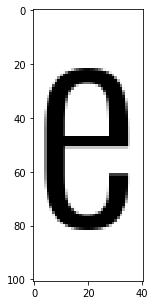

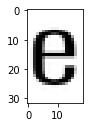

In [106]:
print("Shape or: ", np.array(sample).shape)
print(ocr(sample.convert('L'), "merriweather", True, False))

character = 'e'
patt = Image.open(merriweather_path + character + '.png').convert('RGB')
resized = patt.resize((int(patt.width/2.1), int(patt.height/3.1)), resample=Image.LANCZOS)

print(np.array(patt).shape)

maximas = find_pattern_in(Image.open(merriweather_path + 'sample.png'), resized, 0.95)[1]

placements = {}
for i in range(maximas.shape[0]):
        for j in range(maximas.shape[1]):
            if maximas[i][j]:
                placements[(i,j)] = character

print(placements)
remove_duplicats(placements, np.array(resized).shape)
print(placements)
    
show_image(patt, 20)
show_image(resized)